# Уменьшение размерности

Когда у нас много независимых переменных $x_1, x_2, ... x_n$ (атрибутов), нам часто хочется уменьшить количество атрибутов.
Мы хотим сохранить основные атрибуты и отказаться от тех атрибутов, которые добавляют мало (или вообще не добавляют) новой информации.
Процедура извлечения информативных атрибутов называется уменьшением размерности. Применение: для ускорения обучения модели (например, модели линейной регрессии), удаления неинформативных атрибутов и визуализации многомерных данных.

### Набор данных
Какие факторы больше всего влияют на счастливую жизнь? Из предложенных ответов выберите 3, которые оказывают наибольшее влияние (положительное или отрицательное):
<форма>
     <input type="checkbox"> 1. Здоровье — сколько людей заботятся о своем здоровье.
     <br><input type="checkbox"> 2. Одиночество – насколько одиноким чувствует себя человек.
     <br><input type="checkbox"> 3. Остроумие – насколько человек остроумен.
     <br><input type="checkbox"> 4. Благотворительность - насколько человек участвует в пожертвованиях на благотворительные цели.
     <br><input type="checkbox"> 5. Агрессивность – насколько человек проявляет гнев и гнев.
     <br><input type="checkbox"> 6. Энергия. Сколько энергии есть у человека.
     <br><input type="checkbox"> 7. Количество друзей — сколько друзей у человека.
</форма>

Ниже мы постараемся ответить на этот вопрос, используя данные (подробнее о данных можно прочитать на [ссылка](https://www.kaggle.com/datasets/mirlavsabo/young-people-survey/data)).
Данные были собраны в ходе опроса 2013 года, в ходе которого респонденты (от 15 до 30 лет) ответили на 150 вопросов о музыке, кино, здоровье, религии, личности, взглядах на жизнь, привычках... Каждый признак (столбец) представляет собой ответ. на один вопрос. Каждый вопрос представлен столбцом в файле [responses.csv](data/responses.csv). Объяснение каждого столбца можно найти в файле [columns.csv](data/columns.csv). В каждой строке — один человек (ее ответы на вопросы).

Мы фокусируемся на 57 вопросах об отношениях, убеждениях и привычках (не смотрим на ответы о музыке, фильмах и т. д.). На основе признаков анализируем, что оказывает наибольшее влияние на счастливую жизнь (рубрика «Счастье в жизни»).
**Цель: регрессионная модель, прогнозирующая уровень счастья (столбец «Счастье в жизни») на основе других атрибутов.**

Для начала загружаем необходимые пакеты, функции и датасет:

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sb
import pandas as pd
import numpy as np

import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

matplotlib.rcParams['figure.figsize'] = (6, 3)
sb.set(font_scale=1.)

np.random.seed(42)

def get_fitted_model(x, y):
    '''Составляет модель, используя пакет `statsmodels`.'''
    x_with_const = sm.add_constant(x, has_constant='add')
    model = sm.OLS(y, x_with_const).fit()
    return model

def plot_correlation_for_col(df, col_name):
    plt.figure(figsize=(12,6)) # устанавливаем размер графика
    correlation_matrix = df.corr() # вычисляем матрицу корреляции
    sorted_col_corr = correlation_matrix[col_name].sort_values(ascending=True) # индексируем столбец и сортируем значения
    sorted_col_corr = sorted_col_corr.drop(col_name) # удаляем значение самого себя
    sb.barplot(x=sorted_col_corr.index, y=sorted_col_corr.values, palette='RdBu')
    plt.xticks(rotation=90);
    plt.tight_layout()
    plt.show()

def plot_explained_variance(pca_model):
    '''Строит график объясненной дисперсии с использованием обученной модели PCA.'''
    plt.figure(figsize=(9,3)) # устанавливаем размер графика
    
    explained_variance = pca_model.explained_variance_ratio_
    cumulative_variance = explained_variance.cumsum()

    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.8, align='center')
    plt.xlabel('Главная компонента')
    plt.ylabel('Объясненная дисперсия')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, '--o')
    plt.xlabel('Количество главных компонент')
    plt.ylabel('Кумулятивная дисперсия')

    plt.tight_layout()
    plt.show()

def plot_pc_loading(pca_model, pc_idx, columns, largest_n_pc=None):
    plt.figure(figsize=(12,6)) # устанавливаем размер графика

    pc_loadings_df = pd.DataFrame(data=pca_model.components_, columns=columns)
    loading = pc_loadings_df.iloc[pc_idx]
    sorted_loading_abs = loading.abs().sort_values(ascending=True)

    largest_n_pc = 0 if largest_n_pc is None else largest_n_pc
    sorted_loading = loading[sorted_loading_abs.index][-largest_n_pc:]
    sb.barplot(x=sorted_loading.index, y=sorted_loading.values, palette='Reds')
    plt.xticks(rotation=90);
    plt.title(f'Корреляция атрибутов с {pc_idx}. компонентой')
    plt.tight_layout()
    plt.show()


def visualize_principal_components(principal_components:np.ndarray, n_principal_components:int, target_col=None):
    '''
    Визуализирует главные компоненты в 2D или 3D.

    Parameters:
    - principal_components (np.ndarray): Главные компоненты для визуализации.
    - n_principal_components (int): Количество главных компонент (2 или 3).
    - target_col (pd.Series): Целевой столбец для дифференциации цвета на графике.
    '''
    if n_principal_components == 2:
        fig = px.scatter(x=principal_components[:, 0], y=principal_components[:, 1],
                    opacity=0.6, color=target_col, color_continuous_scale='RdBu', width=700, height=600)
        fig.update_traces(marker={'size':10})
        fig.update_layout(title='Визуализация главных компонент', xaxis_title="PC1", yaxis_title="PC2")

        fig.show()

    elif n_principal_components == 3:
        fig = px.scatter_3d(x=principal_components[:, 0], y=principal_components[:, 1], z=principal_components[:, 2],
            opacity=0.6, color=target_col, color_continuous_scale='RdBu', width=1000)
        fig.update_traces(marker={'size':6})
        fig.update_layout(title='Визуализация главных компонент', scene=dict(xaxis_title="PC1", yaxis_title="PC2", zaxis_title="PC3",
                                     xaxis_autorange='reversed', yaxis_autorange='reversed')) 
        fig.show()
    
    else: raise Exception('number of principal components must 2  or 3')

In [2]:
df = pd.read_csv('data/responses.csv', sep=',')
print(f'Общее количество строк: {df.shape[0]} и атрибутов: {df.shape[1]}')
df.head()


Общее количество строк: 1010 и атрибутов: 150


,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,...,20.0,163.0,48.0,1.0,female,right handed,college/bachelor degree,no,village,block of flats
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,...,19.0,163.0,58.0,2.0,female,right handed,college/bachelor degree,no,city,block of flats
2,5.0,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,...,20.0,176.0,67.0,2.0,female,right handed,secondary school,no,city,block of flats
3,5.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,...,22.0,172.0,59.0,1.0,female,right handed,college/bachelor degree,yes,city,house/bungalow
4,5.0,3.0,4.0,3.0,2.0,4.0,3.0,5.0,3.0,1.0,...,20.0,170.0,59.0,1.0,female,right handed,secondary school,no,village,house/bungalow


### Предварительная обработка
Мы не используем все 150 атрибутов, а фокусируемся на ответах об отношениях, убеждениях и привычках. Мы извлекаем эти столбцы и удаляем пропущенные значения. Затем мы проверяем, все ли столбцы имеют числовые значения (некоторые столбцы не имеют числовых значений). Ответы обычно варьируются от 1 (полностью не согласен) до 5 (полностью согласен), но некоторые ответы представляют собой строки, а не цифры от 1 до 5.

In [3]:
df = df.iloc[:, 76:76+57] # извлекаем столбцы, содержащие ответы на убеждения/привычки
df = df.dropna() # удаляем строки с отсутствующими значениями

# мы хотим предсказать уровень счастья человека
y = df['Happiness in life']

# мы получим ошибку при обучении модели, потому что некоторые столбцы содержат строки
# x, y = df.drop(columns=['Happiness in life']), df['Happiness in life']
# model = get_fitted_model(x, y)

# проверяем, какие столбцы не содержат числа
cols = df.select_dtypes(exclude=['int', 'float']).columns
print(cols)

Index(['Punctuality', 'Lying', 'Internet usage'], dtype='object')


### Категориальные значения
Некоторые вопросы имеют не числовые значения, а категориальные значения. Категориальные значения должны быть преобразованы в числовые (числа), чтобы мы могли обучать модель. Этот вид преобразования данных называется кодированием.
В нашем примере категориальными атрибутами и их значениями являются:
- Пунктуальность – «Я всегда прихожу вовремя», «Я часто прихожу раньше», «Я часто опаздываю»
- Ложь - «никогда», «иногда», «каждый раз, когда мне удобно», «только чтобы не причинить кому-то вреда»
- Использование Интернета – «несколько часов в день», «менее часа в день», «большую часть дня», «совсем нет времени».

***Порядковая кодировка*** — каждая категория кодируется в числовое значение в зависимости от порядка. Используем, когда в категориях есть порядок.
Мы используем метод `map()` для кодирования столбцов *Пунктуальность* и *Использование Интернета*, поскольку в этих категориях существует порядок.

***Горячее кодирование*** — кодирует каждую категорию с помощью горячего вектора. Горячий вектор содержит все нули и единицу в позиции, представляющей категорию (например, [0, 0, 1, 0]). Используем, когда нет четкого порядка в категориях.
Мы используем метод pd.get_dummies() для кодирования *лежащего* столбца, в котором нет четкого порядка в категориях. Мы заменим столбец *Лежа* четырьмя новыми столбцами (потому что у нас есть 4 возможных категории). Например, мы заменим значение «большую часть дня» на вектор [0, 0, 1, 0] (единица в столбце соответствующей категории и ноль в остальных столбцах).

*Примечание: в `pd.get_dummies(... drop_first=True)` мы помещаем параметр `drop_first=True`, чтобы отбросить первый категориальный атрибут и избежать идеальной коллинеарности в данных.*

In [4]:
df['Punctuality'] = df['Punctuality'].map({'i am often running late': 0, 'i am always on time': 1, 'i am often early': 2})
df['Internet usage'] = df['Internet usage'].map({'no time at all': 0, 'less than an hour a day': 1, 'few hours a day': 2, 'most of the day': 3})

df = pd.get_dummies(df, columns=['Lying'], drop_first=True).astype(int)

x, y = df.drop(columns=['Happiness in life']), df['Happiness in life']
model = get_fitted_model(x, y)
print(f'adj r^2={model.rsquared_adj:.5f}')

adj r^2=0.39603


Текущая модель использует 58 атрибутов (столбцов) для оценки уровня счастья.
Давайте посмотрим, насколько каждый атрибут по отдельности влияет на целевой столбец *Счастье в жизни*.
Мы наблюдаем корреляцию со столбцом счастья. Вместо большой корреляционной матрицы мы наблюдаем только одну строку корреляционной матрицы — *Счастье в жизни*.

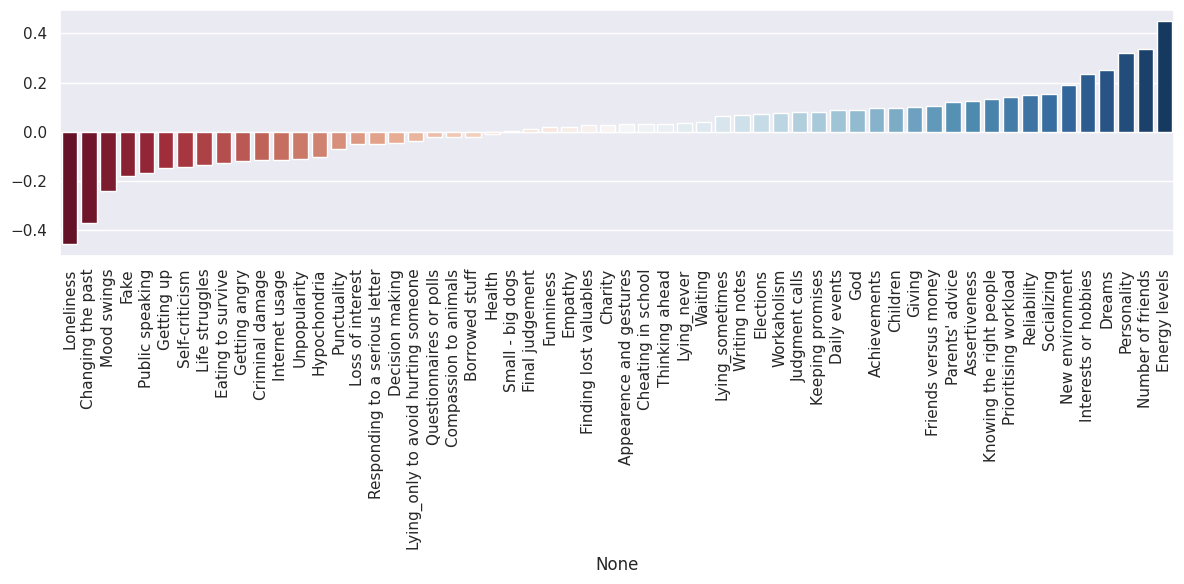

In [5]:
plot_correlation_for_col(df, col_name='Happiness in life')

Мы видим, что самая высокая отрицательная корреляция наблюдается с атрибутом «Одиночество», а самая высокая положительная корреляция – с атрибутом «Уровни энергии». Эти две колонки по отдельности оказывают наибольшее влияние на уровень счастья. Мы ожидаем, что основные компоненты будут во многом зависеть от этих атрибутов, как мы покажем ниже.

<img style="float:right; max-width:400px" src="imgs/pca.png" width="60%" />

## ПКА
Существует несколько алгоритмов снижения размерности, и мы используем анализ главных компонент — PCA (англ. *Principal Component Analysis*).
PCA формирует новые атрибуты из исходных атрибутов (мы называем их **компонентами**). Каждый компонент представляет собой линейную комбинацию исходных атрибутов.
PCA находит компоненты, которые содержат больше всего информации. Он формирует компоненты так, что информативные признаки имеют наибольшую значимость, а неинформативные атрибуты имеют малое значение. Откуда PCA узнает, какие атрибуты являются информативными? Это признаки, которые имеют наибольшую изменчивость (широко разбросанные данные).
Альтернативная формулировка: PCA находит новую систему координат, которая минимизирует общую ошибку реконструкции.

### Предварительная обработка
Очень важным шагом перед применением алгоритма PCA является предварительная обработка. Данные должны быть центрированы и желательно масштабированы так, чтобы они находились в одном диапазоне (большие различия в диапазонах являются проблемой для алгоритма PCA).
Ниже приведен код стандартизации, который центрирует и масштабирует данные. Мы используем класс StandardScaler().

*Примечание. Существуют различные механизмы масштабирования данных (Normalizer, MaxAbsScaler, MinMaxScaler,...). Какой из них лучше, зависит от проблемы и самих данных. Разные механизмы дают разные результаты.*

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
x_scaled = scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns=x.columns)
df['Happiness in life'] = y.values
df.head()

,Daily events,Prioritising workload,Writing notes,Workaholism,Thinking ahead,Final judgement,Reliability,Keeping promises,Loss of interest,Friends versus money,...,Finding lost valuables,Getting up,Interests or hobbies,Parents' advice,Questionnaires or polls,Internet usage,Lying_never,Lying_only to avoid hurting someone,Lying_sometimes,Happiness in life
0,-0.942941,-0.518185,1.354395,0.781611,-1.272082,1.744606,0.150479,-0.001309,-1.229884,-0.715353,...,0.119092,-1.237266,-0.457295,0.850795,0.209656,0.045307,4.316985,-0.609449,-1.102445,4
1,-0.060275,-0.518185,0.649457,1.564127,0.494926,-1.175180,0.150479,-0.001309,0.259422,0.189574,...,0.922960,1.064954,-0.457295,-1.482815,0.209656,0.045307,-0.231643,-0.609449,0.907075,4
2,-1.825608,-0.518185,1.354395,-0.000906,1.378430,0.284713,0.150479,1.130062,-1.229884,1.094501,...,0.119092,0.297548,1.242072,-0.316010,-1.638744,0.045307,-0.231643,-0.609449,0.907075,4
3,-0.060275,-1.335178,-0.760419,-0.000906,1.378430,1.744606,1.216165,-0.001309,-0.485231,-0.715353,...,-0.684777,0.297548,-0.457295,-0.316010,0.209656,0.045307,-0.231643,-0.609449,-1.102445,3
4,-0.942941,-0.518185,-0.055481,-0.000906,-0.388578,-1.175180,-0.915207,-0.001309,0.259422,-1.620281,...,0.119092,-0.469859,1.242072,-0.316010,1.133857,0.045307,-0.231643,1.640825,-1.102445,3


### Применение PCA к данным
В текущей модели множественной регрессии много атрибутов, и значительная часть из них не нужна. Поэтому мы уменьшаем размерность с целью сохранить наиболее важные атрибуты в компонентах.

Мы применяем PCA к данным и в результате получаем компоненты в `principal_comComponents`. Вместо исходных 57 атрибутов мы получаем 50 новых атрибутов.
Мы выбираем первые компоненты *K=50* и на основе этих данных ищем параметры регрессионной модели.

In [7]:
x = df.drop(columns=['Happiness in life'])
y = df['Happiness in life']

# создаем модель PCA
pca_model = PCA(n_components=50, random_state=42)
# применяем PCA к исходным признакам
principal_components = pca_model.fit_transform(x)
# процент информации, сохраненной из исходных данных
print(f'общая дисперсия: {sum(pca_model.explained_variance_ratio_) * 100:.1f}%')

# вместо исходных данных используем главные компоненты для поиска параметров линейной модели
model = get_fitted_model(x=principal_components, y=y)
print(f'adj r^2={model.rsquared_adj:.5f}')

общая дисперсия: 94.7%
adj r^2=0.39024


При этом мы сократили количество компонентов, а скорректированная мера $r^2$ осталась ~ прежней и удалили ~5% ненужной информации.

### Выбор *K*
Как нам выбрать количество компонентов *K*, которые мы оставим? Если цель — визуализация данных, то выбираем $K=2$ или $K=3$.
Если цель состоит в том, чтобы обучить модель быстрее, мы смотрим, насколько каждый компонент объясняет дисперсию данных. Тогда мы можем выбрать *K* так, чтобы:
- сохранить определенный процент от общей дисперсии (например, 95%, как в нашем случае) или,
- используем «метод локтя» и определяем количество компонентов, которые следует сохранить через график.

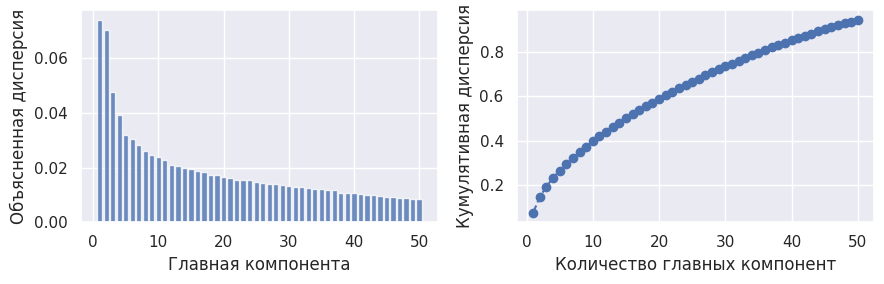

In [8]:
plot_explained_variance(pca_model)

In [9]:
# PCA с 10 компонентами - мы теряем много информации, но получаем намного более простую модель
pca_model = PCA(n_components=10, random_state=42)
principal_components = pca_model.fit_transform(x)
print(f'общая дисперсия: {sum(pca_model.explained_variance_ratio_) * 100:.1f}%')

model = get_fitted_model(x=principal_components, y=y)
print(model.summary())


общая дисперсия: 39.6%
                            OLS Regression Results                            
Dep. Variable:      Happiness in life   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     44.52
Date:                Thu, 08 Feb 2024   Prob (F-statistic):           3.17e-71
Time:                        17:36:56   Log-Likelihood:                -882.16
No. Observations:                 864   AIC:                             1786.
Df Residuals:                     853   BIC:                             1839.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6944      0.

### Интерпретация основных компонентов
Чтобы иметь возможность интерпретировать компоненты, мы должны рассчитать корреляцию компонента и исходных атрибутов. Мы наблюдаем сильнейшие корреляции по абсолютной величине.

Первый главный компонент PC1 имеет наибольшую корреляцию с: уровнем энергии, количеством друзей, хобби, одиночеством,...
Мы видим, что ПК1 отражает неактивность человека (через необщительность). PC1 увеличивается при увеличении бездействия, т.е. PC1 снижается при повышении общительности.
Отрицательный коэффициент при PC1 (видно из `model.summary()`) указывает на обратную зависимость ➡️ уровень счастья увеличивается при уменьшении PC1, а PC1 снижается при повышении коммуникабельности ➡️ у общительных и энергичных людей более высокий уровень счастья.

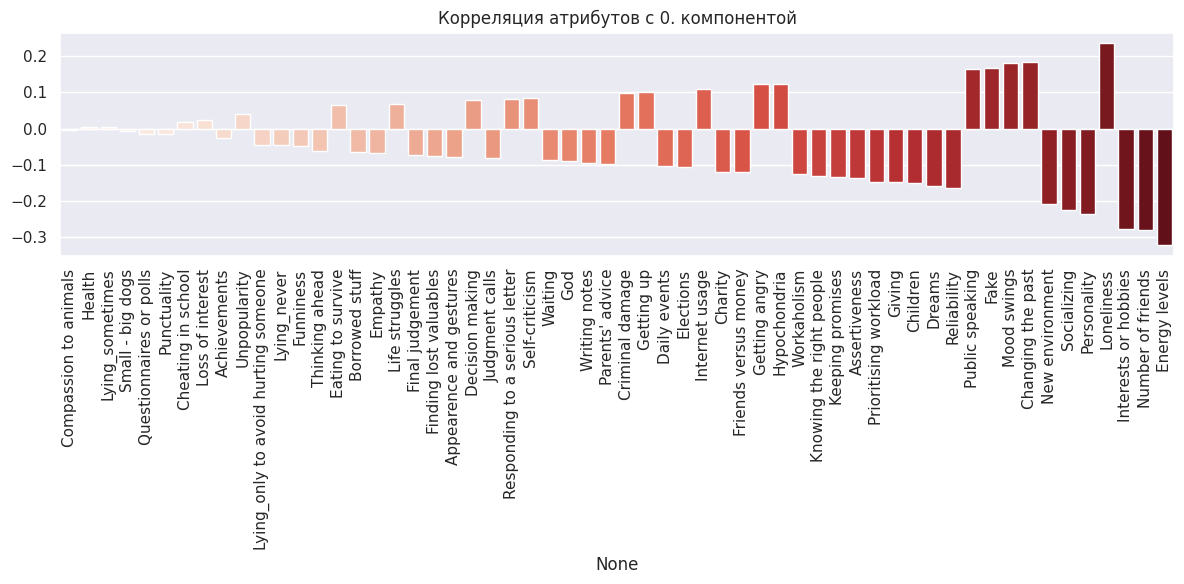

In [10]:
plot_pc_loading(pca_model, 0, x.columns)

Мы видим, что ПК2 больше всего ассоциируется с подготовленностью, организованностью, трудолюбием, ответственностью...
PC2 увеличивается при повышении этих качеств.
Коэффициент со вторым основным компонентом слегка отрицательный ➡️ уменьшение упомянутых характеристик немного увеличивает уровень счастья.

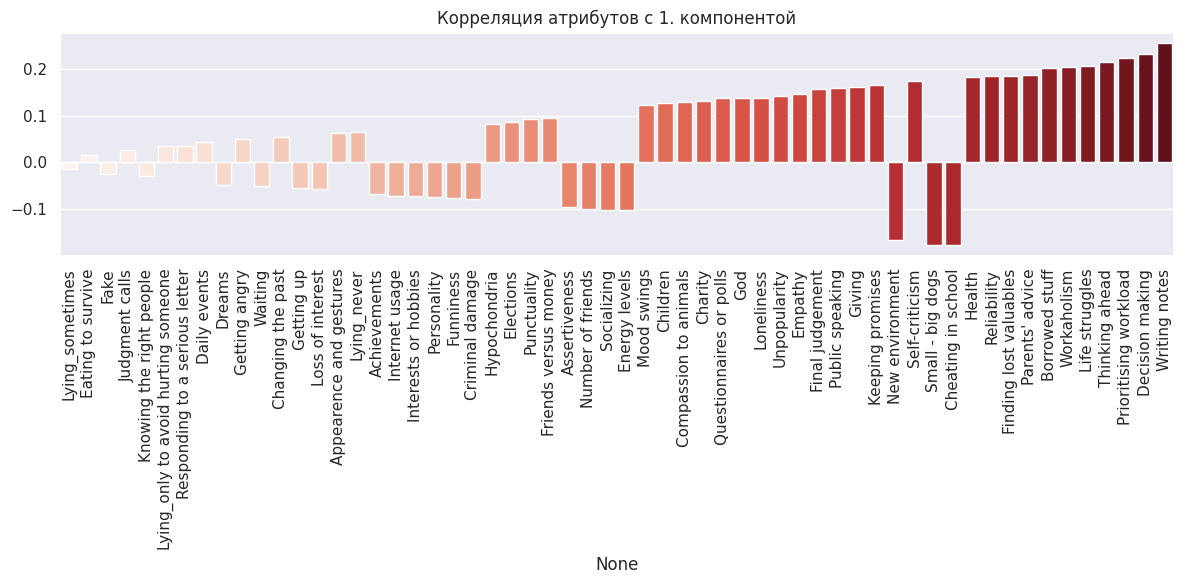

In [11]:
plot_pc_loading(pca_model, 1, x.columns)

Третий основной компонент PC3 больше всего связан с выражением гнева, агрессивности, разрушения, обмана...
PC3 увеличивается по мере увеличения агрессивности.
Коэффициент при ПК3 слегка отрицательный ➡️ снижение агрессивности немного повышает уровень счастья.

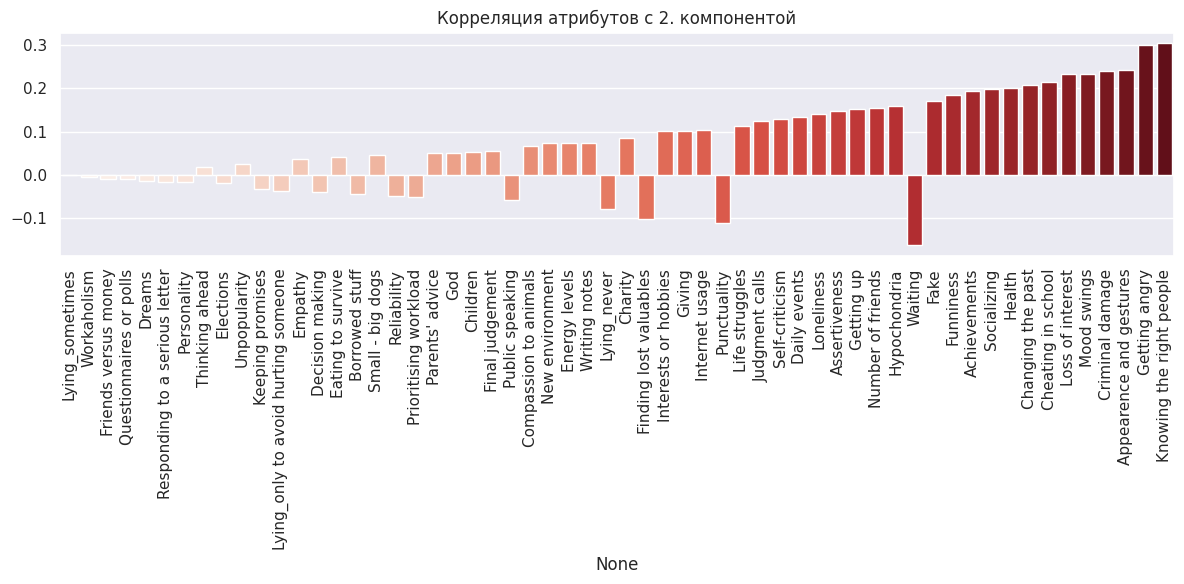

In [12]:
plot_pc_loading(pca_model, 2, x.columns)

Вкратце, мы применили PCA и обучили модель. Результаты алгоритма PCA показывают, что энергичность, подготовленность и агрессивность являются основными компонентами, влияющими на уровень счастья.

### PCA-визуализация
Мы можем показать первые 2 или 3 компонента на графике, где каждая точка представляет человека (каждая строка данных содержит ответы человека). На графике четко видна структура данных.
Красные точки указывают на низкий уровень счастья, а синие точки — на высокий уровень счастья.
ПК1 – активность увеличивается по мере снижения значений.
ПК2 – готовность увеличивается по мере увеличения значений.

На 2D-графике мы видим, что у счастливых людей низкое значение первого и второго компонентов (активные и менее подготовленные люди).
На 3D-графике мы видим, что у счастливых людей низкое значение первого, второго и третьего компонентов (активные, менее подготовленные и неагрессивные люди).

Отметим, что первый компонент оказывает большее влияние на уровень счастья, чем второй.

In [13]:
visualize_principal_components(principal_components, n_principal_components=3, target_col=df['Happiness in life'])

### Интерпретация моделей с 2 ​​и 3 главными компонентами

Мы обучили модель с тремя основными компонентами. Общая дисперсия составляет 19%, а показатель скорректированного $r^2$ немного уменьшился. В регрессионной модели наибольший коэффициент (по абсолютной величине) у ПК1. Это говорит о том, что на уровень счастья больше влияет активность/коммуникабельность человека, чем организованность/трудолюбие, что также подтверждается визуализацией на графике. С другой стороны, агрессивность меньше всего влияет на уровень счастья.

In [14]:
x = df.drop(columns=['Happiness in life'])
pca_model = PCA(n_components=3, random_state=42)
principal_components = pca_model.fit_transform(x)
print(f'{sum(pca_model.explained_variance_ratio_) * 100:.1f}%')

model = get_fitted_model(x=principal_components, y=df['Happiness in life'])
print(model.summary())

19.2%
                            OLS Regression Results                            
Dep. Variable:      Happiness in life   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     118.8
Date:                Thu, 08 Feb 2024   Prob (F-statistic):           2.25e-64
Time:                        17:36:58   Log-Likelihood:                -913.82
No. Observations:                 864   AIC:                             1836.
Df Residuals:                     860   BIC:                             1855.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6944      0.024    155.488   

Теперь мы можем ответить на вопрос, поставленный в начале урока. Согласно данным, на счастье больше всего влияют:
2. Одиночество (негативное), 6. Энергия (положительное), 7. Количество друзей (положительное)

Эти результаты кажутся логичными, и их можно связать с наблюдениями исследования, проведенного Гарвардом. На основании этого исследования можно сделать вывод, что избегание одиночества и развитие межличностных отношений положительно влияют на уровень счастья. Кроме того, повышенная энергия и количество друзей способствуют увеличению счастья. Подробности на [ссылка](https://youtu.be/vSQjk9jKarg?si=kXW_tRS_OGR7adNP) и на [ссылка](https://www.youtube.com/watch?v=8KkKuTCFvzI).

## Задания
**ЗАДАЧА 1**: Загрузите набор данных «Люди», используя демографические данные и информацию о расходах (от столбца 134 до конца). Удалите столбец «Вес». Выполните анализ PCA (используя метод локтя для выбора соответствующего количества компонентов *K*), а затем создайте модель линейной регрессии для прогнозирования «Высоты». Наконец, подробно объясните основные компоненты, включенные в модель.